# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [20]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.stats import zmap
from sklearn import svm

import torch
torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {device}")

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec


# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla
import alens_analysis.helpers as ahlp

# Locations
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

# Ke_path = cond_path / '22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200'
# Ke_path = cond_path / '22-12-07_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200'
# ls_path = cond_path / '22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07'
# ko_path = cond_path / '22-10-16_aLc1_line800_sticky55nm_kod.1-300'

Ke_ls_path = cond_path / "22-12-08_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200"
Ke_ls_equil_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil"
Ke_ls_ks25_equil_path = cond_path / "23-02-27_aLchr1_slice8.8.12_line800_ks25_Ls0.1-0.7_kod3_Ke1-200_equil"
Ke_ks_ls20_equil_path = cond_path / "23-02-27_aLchr1_slice8.8.12_line800_Ls20nm_kod3_ks1-200_Ke1-200_equil"
Ke_ks_ls55_equil_path = cond_path / "23-02-27_aLchr1_slice8.8.12_line800_Ls55nm_kod3_ks1-200_Ke1-200_equil"



# Style and graphing
from cond_char_style import cond_char_sty
plt.style.use(cond_char_sty)
marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')

SAW_RG = .486918



'1.13.0'

Torch device: cuda


# Collect and save analyzed data

In [2]:
def save_slice_rog_data(run_path,
                    param_str_list, 
                    ss_rog_avg_start_ind=-600,
                    ss_ind = 1,
                    end_ind = -1,
                    start_bead = 0,
                    end_bead = None,
                  ):
    # Make analysis directory if it doesn't exist
    anal_path = (run_path / 'analysis')
    anal_path.mkdir(exist_ok=True)


    # Create an hdf5 file
    h5_path = anal_path / 'rog_slice_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['params'] = param_str_list

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str_list[0]}(\d*\.?\d+)_{param_str_list[1]}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        for i, pd in tqdm(enumerate(param_dirs)):
            rog_arrs = []
            clps_times = []
            avg_clps_rog_arr = []
            std_clps_rog_arr = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                print(f'No data files found for parameter directory {pd}')
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from seed h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                rog = aa.calc_rad_of_gyration(com_arr)
                clps_ind = ahlp.find_steady_state_ind(
                    rog, [ss_rog_avg_start_ind, None])
                rog_arrs += [rog.tolist()]
                clps_times += [time_arr[clps_ind]]
                avg_clps_rog_arr += [rog[clps_ind:].mean()]
                std_clps_rog_arr += [rog[clps_ind:].std()]

            for h5d in sd_h5_data_lst:
                h5d.close()

            # Make sure the runs are all the same length
            min_length = min([len(_) for _ in rog_arrs])
            rog_arrs = np.array([_[:min_length] for _ in rog_arrs])

            # Create dataset
            match = mp.match(pd.name)
            pvals = [match[1], match[2]]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  rog_arrs.mean(axis=0)[:, np.newaxis],
                                  rog_arrs.std(axis=0)[:, np.newaxis]))
            print(data_arr.shape)
            d_set = h5_file.create_dataset(pd.name, data=data_arr)
            d_set.attrs[param_str_list[0]] = pvals[0]
            d_set.attrs[param_str_list[1]] = pvals[1] 
            d_set.attrs['seeds'] = rog_arrs.shape[0]
            d_set.attrs['collapse_times'] = clps_times
            d_set.attrs['avg_collapse_rog'] = avg_clps_rog_arr
            d_set.attrs['std_collapse_rog'] = std_clps_rog_arr

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            

            for h5d in sd_h5_data_lst:
                h5d.close()


# Saving data

In [21]:
# save_slice_rog_data(Ke_ls_path, param_str_list=["Ls","Ke"])

# save_slice_rog_data(Ke_ls_equil_path, param_str_list=["Ls","Ke"])
# save_slice_rog_data(Ke_ls_ks25_equil_path, param_str_list=["Ls","Ke"])

# save_slice_rog_data(Ke_ks_ls20_equil_path, param_str_list=["ks","Ke"])
# save_slice_rog_data(Ke_ks_ls55_equil_path, param_str_list=["ks","Ke"])

0it [00:00, ?it/s]

(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)
(3600, 3)


# Graphing

In [6]:
def collapse_time_and_rog_phase_diagram(fig, axarr, h5_path, scale_mark_size=False):

    axarr[0].sharey(axarr[1])
    axarr[0].sharex(axarr[1])

    with h5py.File(h5_path, 'r') as h5d:
        params = h5d.attrs['params']
        # Sort by the first parameter in params list
        avg_clps_times_arr = []
        std_clps_times_arr = []
        rog_avg = []
        rog_std = []
        p1_val_list = []
        p2_val_list = []

        for h5_dset in h5d.values():
            p1_val_list += [float(h5_dset.attrs[params[0]])]
            p2_val_list += [float(h5_dset.attrs[params[1]])]
            avg_clps_times_arr += [np.mean(h5_dset.attrs['collapse_times'])]
            std_clps_times_arr += [np.std(h5_dset.attrs['collapse_times'])]
            rog_avg += [np.mean(h5_dset.attrs['avg_collapse_rog'])]
            rog_std += [np.std(h5_dset.attrs['avg_collapse_rog'])]


        rog_avg = np.array(rog_avg)/SAW_RG
        rog_std = np.array(rog_std)/SAW_RG
        print(np.max(rog_std))

        clps_size = 500*np.sqrt(std_clps_times_arr/avg_clps_times_arr) if scale_mark_size else 200
        _ = axarr[0].scatter(p1_val_list, p2_val_list,
                             c=mpl.cm.plasma(
                                 avg_clps_times_arr/np.max(avg_clps_times_arr)),
                             s=clps_size,
                             marker='s')
        cb0 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=np.max(avg_clps_times_arr)),
                                                 cmap='plasma'),
                           ax=axarr[0])
        _ = cb0.set_label('Mean collapse time (sec)')

        rog_size = 1000*np.sqrt(rog_std)/rog_avg if scale_mark_size else 200
        _ = axarr[1].scatter(p1_val_list, p2_val_list,
                             c=mpl.cm.plasma(rog_avg/np.max(rog_avg)),
                             s=rog_size,
                             marker='s')
        cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=np.max(rog_avg)),
                                                 cmap='plasma'),
                           ax=axarr[1])
        _ = cb1.set_label('Mean steady-state $R_g$/SAW $R_g$ ')

        X = np.vstack((p1_val_list, np.log10(p2_val_list))).T
        Y = np.array(rog_avg) < 2.*np.max(rog_std)

        clf = svm.SVC(kernel="poly", C=100, gamma="auto", degree=4, coef0=5)
        clf.fit(X,Y)

        xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), 1000), 
                            np.linspace(np.min(X[:,1]), np.max(X[:,1]), 1000)) 
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        axarr[0].contour(xx, np.power(10,yy), Z, levels=[0], linewidths=4, linestyles="dashed")
        axarr[1].contour(xx, np.power(10,yy), Z, levels=[0], linewidths=4, linestyles="dashed")
    
    return p1_val_list, p2_val_list, avg_clps_times_arr, std_clps_times_arr, rog_avg, rog_std



In [7]:
def collapse_rog_phase_diagram(fig, ax, h5_path, scale_mark_size=False):

    with h5py.File(h5_path, 'r') as h5d:
        params = h5d.attrs['params']
        print(params)
        # Sort by the first parameter in params list
        rog_avg = []
        rog_std = []
        p1_val_list = []
        p2_val_list = []

        for h5_dset in h5d.values():
            p1_val_list += [float(h5_dset.attrs[params[0]])]
            p2_val_list += [float(h5_dset.attrs[params[1]])]
            rog_avg += [np.mean(h5_dset.attrs['avg_collapse_rog'])]
            rog_std += [np.std(h5_dset.attrs['avg_collapse_rog'])]


        rog_avg = np.array(rog_avg)/SAW_RG
        rog_std = np.array(rog_std)/SAW_RG
        print(np.max(rog_std))

        rog_size = 1000*np.sqrt(rog_std)/rog_avg if scale_mark_size else 200
        _ = ax.scatter(p1_val_list, p2_val_list,
                             c=mpl.cm.plasma(rog_avg/np.max(rog_avg)),
                             s=rog_size,
                             marker='s')
        cb1 = fig.colorbar(mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=0, vmax=np.max(rog_avg)), 
            cmap='plasma'),
                           ax=ax)
        _ = cb1.set_label('Mean steady-state $R_g$/ $R^{saw}_g$ ')

        # X = np.vstack((p1_val_list, np.log10(p2_val_list))).T
        # Y = np.array(rog_avg) < 2.*np.max(rog_std)

        # clf = svm.SVC(kernel="poly", C=100, gamma="auto", degree=4, coef0=5)
        # clf.fit(X,Y)

        # xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), 1000), 
        #                     np.linspace(np.min(X[:,1]), np.max(X[:,1]), 1000)) 
        # Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        # Z = Z.reshape(xx.shape)

        # # axarr[0].contour(xx, np.power(10,yy), Z, levels=[0], linewidths=4, linestyles="dashed")
        # ax.contour(xx, np.power(10,yy), Z, levels=[0], linewidths=4, #linestyles="dashed", 
        #            colors='red')
    
    return p1_val_list, p2_val_list, rog_avg, rog_std



0.20200203


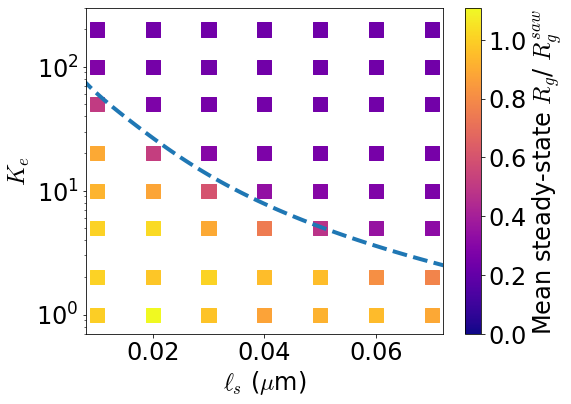

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

with (Ke_ls_equil_path / 'RunConfig.yaml').open('r') as rcf:
    run_params = yaml.safe_load(rcf)
with (Ke_ls_equil_path / 'ProteinConfig.yaml').open('r') as pcf:
    prot_params = yaml.safe_load(pcf)

n=.0003
ks = prot_params['proteins'][0]['kappa']
kbT = float(run_params['KBT'])
a = ks/(2.*kbT)
l = np.linspace(0, .08, 100)

Ke = n / (((1. + (2*a*l*l))*np.sqrt(np.pi)*(1. + erf(np.sqrt(a)*l))) /(4.*np.power(a, 1.5)) + (3. * np.exp(-a*l*l)*l)/(2*a))
_ = ax.plot(l, Ke, linewidth=4, linestyle="dashed")

h5_path = Ke_ls_equil_path / 'analysis/rog_slice_data.h5'
(p1_val_list, p2_val_list, 
 rog_avg, rog_std) = collapse_rog_phase_diagram(fig, ax, h5_path)

_ = ax.set_yscale('log')
_ = ax.set_xlim(0.008, .072)
_ = ax.set_ylim(0.7, 300)
_ = ax.set_xlabel('$\ell_s$ ($\mu$m)')
_ = ax.set_ylabel('$K_e$')
# fig.tight_layout()


0.21004887


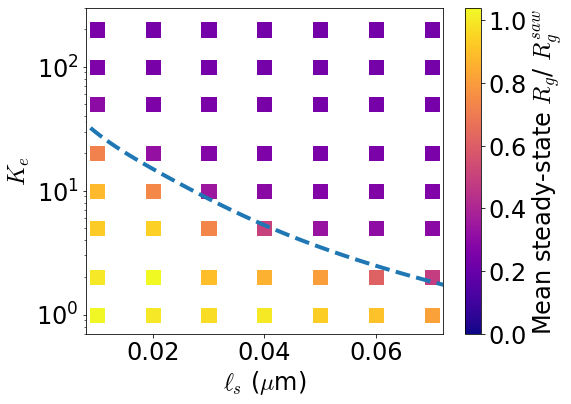

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
data_path = Ke_ls_ks25_equil_path

with (data_path / 'RunConfig.yaml').open('r') as rcf:
    run_params = yaml.safe_load(rcf)
with (data_path / 'ProteinConfig.yaml').open('r') as pcf:
    prot_params = yaml.safe_load(pcf)

n=.0003
ks = prot_params['proteins'][0]['kappa']
kbT = float(run_params['KBT'])
a = ks/(2.*kbT)
l = np.linspace(0, .08, 100)

Ke = n / (((1. + (2*a*l*l))*np.sqrt(np.pi)*(1. + erf(np.sqrt(a)*l))) /(4.*np.power(a, 1.5)) + (3. * np.exp(-a*l*l)*l)/(2*a))
_ = ax.plot(l, Ke, linewidth=4, linestyle="dashed")

h5_path = data_path / 'analysis/rog_slice_data.h5'
(p1_val_list, p2_val_list, 
 rog_avg, rog_std) = collapse_rog_phase_diagram(fig, ax, h5_path)

_ = ax.set_yscale('log')
_ = ax.set_xlim(0.008, .072)
_ = ax.set_ylim(0.7, 300)
_ = ax.set_xlabel('$\ell_s$ ($\mu$m)')
_ = ax.set_ylabel('$K_e$')
# fig.tight_layout()


0.21403804


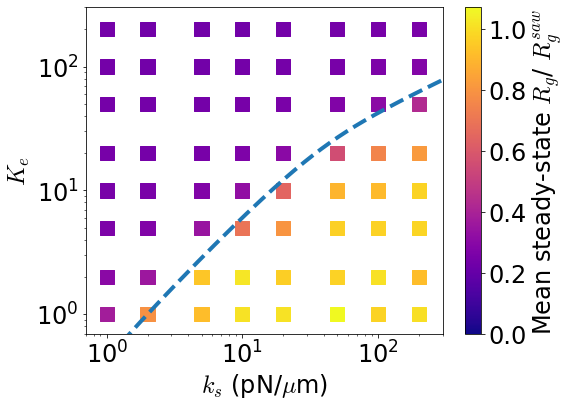

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
data_path = Ke_ks_ls20_equil_path 

with (data_path / 'RunConfig.yaml').open('r') as rcf:
    run_params = yaml.safe_load(rcf)
with (data_path / 'ProteinConfig.yaml').open('r') as pcf:
    prot_params = yaml.safe_load(pcf)

n=.0003
l = float(prot_params['proteins'][0]['freeLength'])
kbT = float(run_params['KBT'])
ks = np.linspace(1, 300, 400)
a = ks/(2.*kbT)

Ke = n / (((1. + (2*a*l*l))*np.sqrt(np.pi)*(1. + erf(np.sqrt(a)*l))) /(4.*np.power(a, 1.5)) + (3. * np.exp(-a*l*l)*l)/(2*a))
_ = ax.plot(ks, Ke, linewidth=4, linestyle="dashed")

h5_path = data_path / 'analysis/rog_slice_data.h5'
(p1_val_list, p2_val_list, 
 rog_avg, rog_std) = collapse_rog_phase_diagram(fig, ax, h5_path)

_ = ax.set_yscale('log')
_ = ax.set_xscale('log')
# _ = ax.set_xlim(0.008, .072)
_ = ax.set_ylim(0.7, 300)
_ = ax.set_xlim(0.7, 300)
_ = ax.set_xlabel('$k_s$ (pN/$\mu$m)')
_ = ax.set_ylabel('$K_e$')
# fig.tight_layout()


['Ls' 'Ke']
0.20200203
[ 0.05322719  0.03770821  0.02265912  0.03424073  0.04214386  0.04243531
  0.04291985  0.0435671   0.04435366  0.04526228  0.04628115  0.04740304
  0.04862459  0.04994556  0.05136814  0.05289633  0.05453538  0.05586184
  0.05688207  0.058032    0.05931778  0.06074512  0.06231911  0.06385517
  0.05522752  0.04690271  0.03888476  0.03117626  0.02377847  0.02371775
  0.02417939  0.0248952   0.02586275  0.02707896  0.02708562  0.0273334
  0.02781796  0.02853471  0.02947889  0.03064556  0.03202974  0.0336264
  0.03545308  0.03750916  0.03976202  0.04220678  0.04483868  0.03752014
  0.02918961  0.02109709  0.0100153  -0.0040615  -0.01791755 -0.03155826
 -0.04498887 -0.05821447 -0.070653   -0.06111791 -0.05149921 -0.04179888
 -0.03201878 -0.02216078 -0.01222662 -0.00221804  0.0078633   0.0180158
  0.02823789  0.02948015  0.02504211  0.02073611  0.01655938  0.01250921
  0.00858296  0.0047781   0.00109215 -0.0024773  -0.00593257 -0.00927592
 -0.01250957 -0.01442878 -0.016

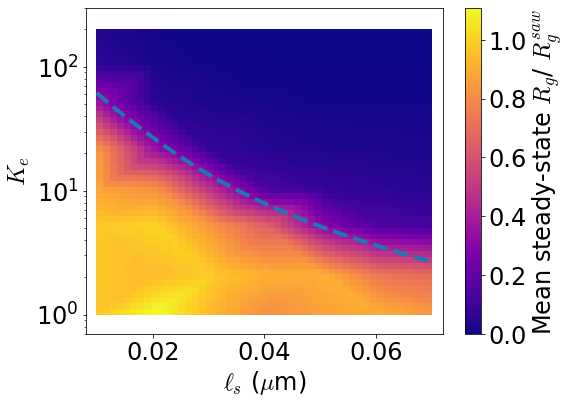

In [38]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
from scipy.optimize import minimize
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

def ke_func(l, n, ks, kbT):
    return n / (((1. + (2*a*l*l))*np.sqrt(np.pi)*(1. + erf(np.sqrt(a)*l))) /(4.*np.power(a, 1.5)) + (3. * np.exp(-a*l*l)*l)/(2*a)) 

def log_ke_func(l, n, ks, kbT):
    return np.log(n / (((1. + (2*a*l*l))*np.sqrt(np.pi)*(1. + erf(np.sqrt(a)*l))) /(4.*np.power(a, 1.5)) + (3. * np.exp(-a*l*l)*l)/(2*a)))

def loss_func(n, r_crit, ls, rog_intp, ks, kbT):
    log_ke = log_ke_func(ls, n, ks, kbT)
    guess = r_crit - rog_intp(ls, log_ke)
    print(guess)
    s = np.sum(np.power(r_crit - rog_intp(ls, log_ke), 2))
    return s
    


with (Ke_ls_equil_path / 'RunConfig.yaml').open('r') as rcf:
    run_params = yaml.safe_load(rcf)
with (Ke_ls_equil_path / 'ProteinConfig.yaml').open('r') as pcf:
    prot_params = yaml.safe_load(pcf)
n = .0003
ks = prot_params['proteins'][0]['kappa']
kbT = float(run_params['KBT'])
a = ks/(2.*kbT)
l = np.linspace(.01, .07, 100)
Ke = ke_func(n, l, ks, kbT)

h5_path = Ke_ls_equil_path / 'analysis/rog_slice_data.h5'
with h5py.File(h5_path, 'r') as h5d:
    params = h5d.attrs['params']
    print(params)
    # Sort by the first parameter in params list
    rog_avg = []
    rog_std = []
    p1_val_list = []
    p2_val_list = []

    for h5_dset in h5d.values():
        p1_val_list += [float(h5_dset.attrs[params[0]])]
        p2_val_list += [float(h5_dset.attrs[params[1]])]
        rog_avg += [np.mean(h5_dset.attrs['avg_collapse_rog'])]
        rog_std += [np.std(h5_dset.attrs['avg_collapse_rog'])]


    ls_arr = np.array(p1_val_list)
    ke_arr = np.log(np.array(p2_val_list))
    rog_avg = np.array(rog_avg)/SAW_RG
    rog_std = np.array(rog_std)/SAW_RG
    print(np.max(rog_std))
    coords = np.vstack((ls_arr, ke_arr))

    interp = LinearNDInterpolator(coords.T, rog_avg, )
    x = np.linspace(ls_arr.min(), ls_arr.max())
    y = np.linspace(ke_arr.min(), ke_arr.max())
    X, Y = np.meshgrid(x,y)
    Z = interp(X,Y)
    X, Y = np.meshgrid(x,np.exp(y))
    _ = ax.pcolormesh(X, Y, Z, cmap='plasma')
    cb1 = fig.colorbar(mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=0, vmax=np.max(rog_avg)), 
            cmap='plasma'),
                           ax=ax)
    _ = cb1.set_label('Mean steady-state $R_g$/ $R^{saw}_g$ ')

    min_stats = minimize(loss_func, [.0003], args=(.5, l, interp, ks, kbT), method='SLSQP',  bounds=[[0.,1.]])
    n=min_stats['x'][0]
print(min_stats)
Ke = ke_func(l, n, ks, kbT) 
_ = ax.plot(l, Ke, linewidth=4, linestyle="dashed")

# (p1_val_list, p2_val_list, 
#  rog_avg, rog_std) = collapse_rog_phase_diagram(fig, ax, h5_path)

_ = ax.set_yscale('log')
_ = ax.set_xlim(0.008, .072)
_ = ax.set_ylim(0.7, 300)
_ = ax.set_xlabel('$\ell_s$ ($\mu$m)')
_ = ax.set_ylabel('$K_e$')
# fig.tight_layout()


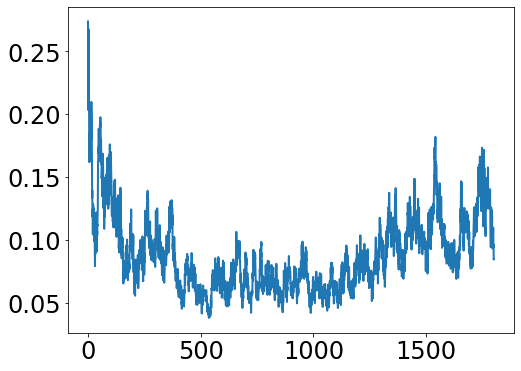

In [42]:
from scipy.spatial import ConvexHull
data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.03_Ke10/s1"
try:
    with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        

        # print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
        # print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")
    # sd_h5_data_lst = []
    # for h5p in param_path.glob('s*/analysis/raw*.h5'):
    #     try:
    #         sd_h5_data_lst += [h5py.File(h5p, 'r')]
    #     except:
    #         print(f'Could not open {h5p}.')

    # with h5py.File(next(param_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
    #     time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    # for h5_data in sd_h5_data_lst:
    #     bistress_ac_arrs += [poly_stress_autocorr(h5_data['bilateral_stress'][...], device=device).cpu().tolist()]
    #     colstress_ac_arrs += [poly_stress_autocorr(h5_data['collision_stress'][...], device=device).cpu().tolist()]
    # bistress_ac_arrs = np.array(bistress_ac_arrs, dtype=float)
    # colstress_ac_arrs = np.array(colstress_ac_arrs)
    # axarr.scatter(time_arr, bistress_ac_arrs.mean(axis=0))
    # axarr.scatter(time_arr, colstress_ac_arrs.mean(axis=0))
except:
    raise

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
axarr.plot(time_arr, hull_vol)

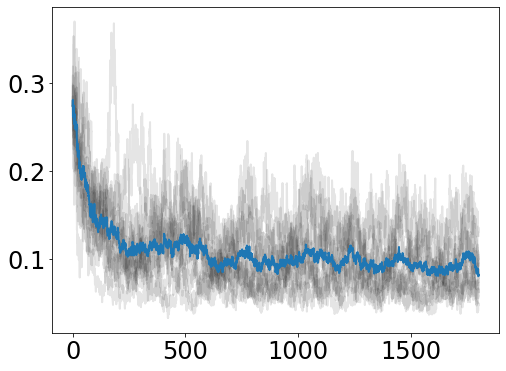

In [45]:
from scipy.spatial import ConvexHull
data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.03_Ke10/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
        
    # bistress_ac_arrs = np.array(bistress_ac_arrs, dtype=float)
    # colstress_ac_arrs = np.array(colstress_ac_arrs)
    # axarr.scatter(time_arr, bistress_ac_arrs.mean(axis=0))
    # axarr.scatter(time_arr, colstress_ac_arrs.mean(axis=0))
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


0.0574919911347306
0.03319489854418634


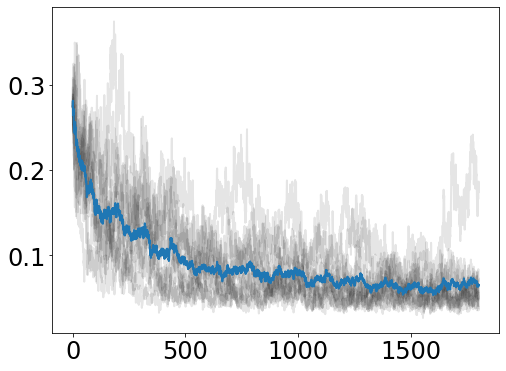

In [53]:
from scipy.spatial import ConvexHull
data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke5/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    hull_mean = hull_vol_list.mean(axis=0)
    _ = axarr.plot(time_arr, hull_mean)
    print(hull_mean[-500].mean())
    hull_min = hull_vol_list.min(axis=0)
    print(hull_min[-500].mean())
        
    # bistress_ac_arrs = np.array(bistress_ac_arrs, dtype=float)
    # colstress_ac_arrs = np.array(colstress_ac_arrs)
    # axarr.scatter(time_arr, bistress_ac_arrs.mean(axis=0))
    # axarr.scatter(time_arr, colstress_ac_arrs.mean(axis=0))
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


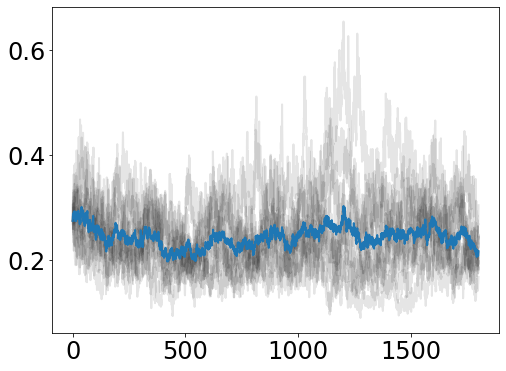

In [50]:
from scipy.spatial import ConvexHull
data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke1/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
        
    # bistress_ac_arrs = np.array(bistress_ac_arrs, dtype=float)
    # colstress_ac_arrs = np.array(colstress_ac_arrs)
    # axarr.scatter(time_arr, bistress_ac_arrs.mean(axis=0))
    # axarr.scatter(time_arr, colstress_ac_arrs.mean(axis=0))
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


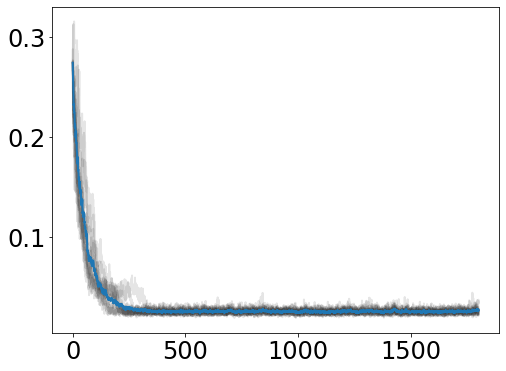

In [51]:
from scipy.spatial import ConvexHull
data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke10/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
        
    # bistress_ac_arrs = np.array(bistress_ac_arrs, dtype=float)
    # colstress_ac_arrs = np.array(colstress_ac_arrs)
    # axarr.scatter(time_arr, bistress_ac_arrs.mean(axis=0))
    # axarr.scatter(time_arr, colstress_ac_arrs.mean(axis=0))
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


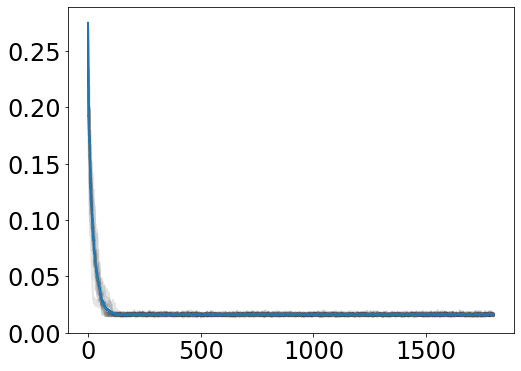

In [48]:
from scipy.spatial import ConvexHull
data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.03_Ke50/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
        
    # bistress_ac_arrs = np.array(bistress_ac_arrs, dtype=float)
    # colstress_ac_arrs = np.array(colstress_ac_arrs)
    # axarr.scatter(time_arr, bistress_ac_arrs.mean(axis=0))
    # axarr.scatter(time_arr, colstress_ac_arrs.mean(axis=0))
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


# Testing figures

In [ ]:
X = np.vstack((p1_val_list, np.log10(p2_val_list))).T

Y = np.array(rog_avg) < .4
print(Y.astype(int))

clf = svm.SVC(kernel="poly", C=100, gamma="auto", degree=4, coef0=5)
# clf = svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
# clf = svm.SVR(kernel="poly", C=100, gamma="auto", degree=4, epsilon=0.1, coef0=5)
clf.fit(X,Y)
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), 1000), 
                    #  np.logspace(np.log10(np.min(X[:,1])), np.log10(np.max(X[:,1])), 100)) 
                     np.linspace(np.min(X[:,1]), np.max(X[:,1]), 1000)) 
# Z = clf.desc(np.c_[xx.ravel(), yy.ravel()])
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
_ = axarr[0].scatter(X[:,0], X[:,1],
                        c=mpl.cm.plasma_r(
                            Y/np.max(Y)),
                        s=200,
                        marker='s')
axarr[0].imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.plasma_r,
)
axarr[0].contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
# # plt.yscale('log')

0.2856234


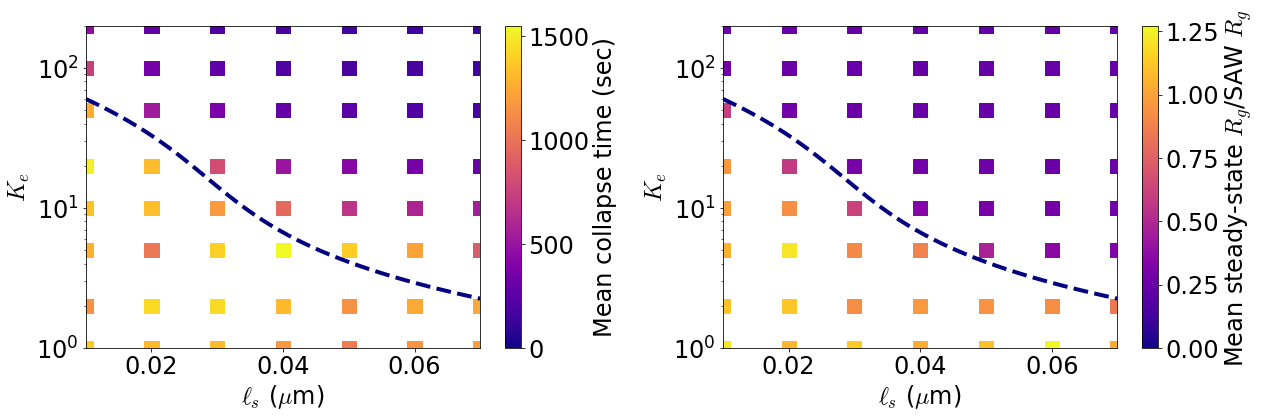

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
h5_path = Ke_ls_path / 'analysis/rog_slice_data.h5'
(p1_val_list, p2_val_list, 
 avg_clps_times_arr, std_clps_times_arr, 
 rog_avg, rog_std) =collapse_time_and_rog_phase_diagram(fig, axarr, h5_path)

axarr[0].set_yscale('log')
# axarr[0].set_xlim(0.008, .072)
for ax in axarr:
    _ = ax.set_xlabel('$\ell_s$ ($\mu$m)')
    _ = ax.set_ylabel('$K_e$')
fig.tight_layout()


# Conclusions and Next Steps

In [ ]:
aa.physical_scales.get_rouse_time(800,.02,1)

198.2660118322395

0.4772498680518208

In [51]:
erfinv(1/np.sqrt(2))

nan